In [11]:
import pm4py
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
import numpy as np
import tqdm
import seaborn as sns

Load dataset with pickle

In [4]:
log = None
with open("data/log_pm4py.pkl", "rb") as f:
    log = pickle.load(f)
log_df = pm4py.convert_to_dataframe(log)


* Frequencies of activities
* Attributi per colonne

# Find which columns are related to the activities

In [5]:
#for each activity, get the non nan attributes
activity_attributes = {}
for activity in log_df["concept:name"].unique():
    activity_attributes[activity] = set(log_df[log_df["concept:name"] == activity].dropna(axis=1, how='all' ).columns)


common_activity_attributes = set.intersection(*activity_attributes.values())


#remove the common attributes from the event attributes
for activity in activity_attributes:
    activity_attributes[activity] = activity_attributes[activity] - common_activity_attributes
    

print(f"Attributes writes by each activity: {common_activity_attributes}")
print('='*35)
print()
for activity in activity_attributes:
    print(f"Attributes writes by {activity}: {activity_attributes[activity]}")
    print(' '*21+'-'*len(activity))

    

Attributes writes by each activity: {'lifecycle:transition', 'time:timestamp', 'concept:name', 'case:concept:name'}

Attributes writes by Create Fine: {'totalPaymentAmount', 'amount', 'dismissal', 'vehicleClass', 'org:resource', 'article', 'points'}
                     -----------
Attributes writes by Send Fine: {'expense'}
                     ---------
Attributes writes by Insert Fine Notification: {'lastSent', 'notificationType'}
                     ------------------------
Attributes writes by Add penalty: {'amount'}
                     -----------
Attributes writes by Send for Credit Collection: set()
                     --------------------------
Attributes writes by Payment: {'totalPaymentAmount', 'paymentAmount'}
                     -------
Attributes writes by Insert Date Appeal to Prefecture: set()
                     --------------------------------
Attributes writes by Send Appeal to Prefecture: {'dismissal'}
                     -------------------------
Attributes w

In [6]:
all_activity_attributes = {}
for activity in log_df["concept:name"].unique():
    all_activity_attributes[activity] = set(log_df[log_df["concept:name"] == activity].dropna(axis=1, how='all' ).columns)
    
any_activity_attributes = {}
for activity in log_df["concept:name"].unique():
    any_activity_attributes[activity] = set(log_df[log_df["concept:name"] == activity].dropna(axis=1, how='any' ).columns)
    
if (all_activity_attributes == any_activity_attributes):
    print("There are no missing values in the attribtues")
else:
    for activity in all_activity_attributes:
        missing_values = all_activity_attributes[activity] - any_activity_attributes[activity]
        if(len(missing_values) > 0):
            print(f"Missing values for activity {activity}: {missing_values}")

Missing values for activity Insert Fine Notification: {'lastSent'}


# Activities frequencies

/var/folders/_f/k63ns_v15qv4kfpd87ckc8lm0000gn/T/ipykernel_52787/1731413599.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


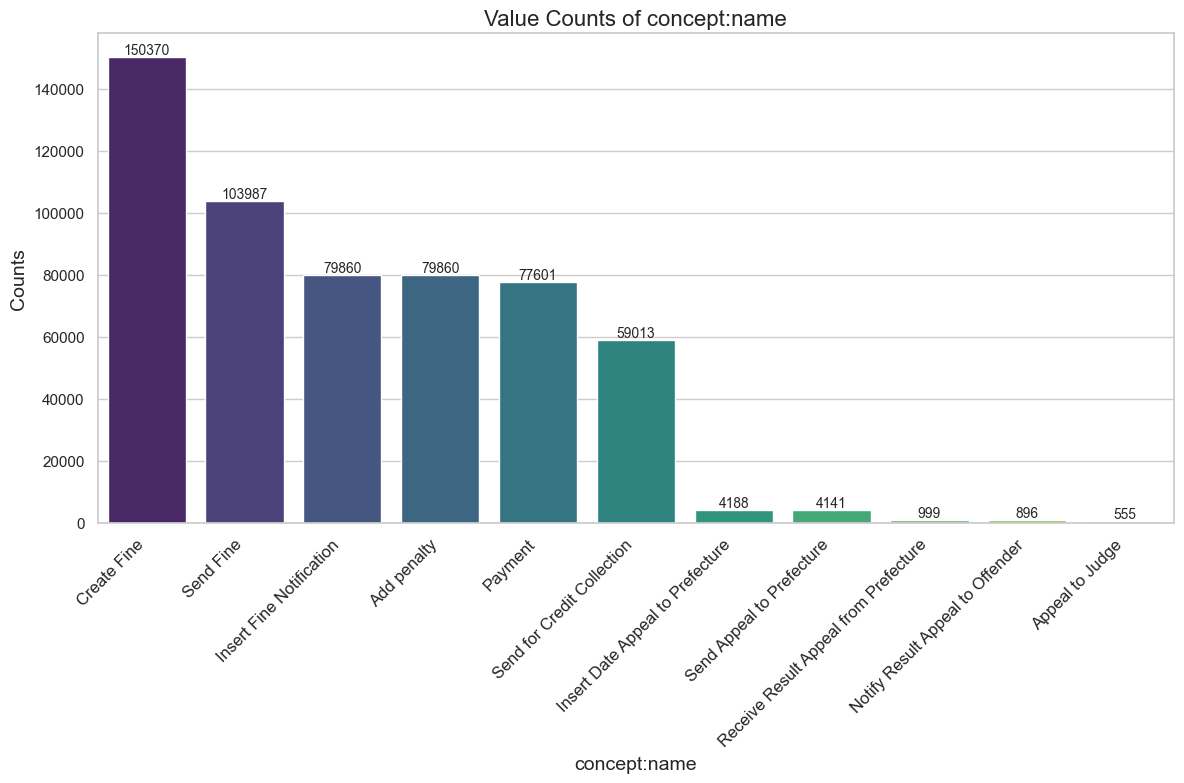

In [13]:
def plot_value_counts(data, column_name, img_path=None):

    plt.figure(figsize=(12, 8))
    

    value_counts = data[column_name].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")

    plt.title(f'Value Counts of {column_name}', fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    
    plt.xticks(rotation=45, ha='right', fontsize=12)

    for index, value in enumerate(value_counts.values):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    
    if img_path:
        plt.savefig(img_path, bbox_inches='tight', dpi=300)
    
    plt.show()

plot_value_counts(log_df, "concept:name", img_path="img/concept_name_value_counts.png")